# Text Classification with Neural Networks

The goal of this project is to develop a **classification model to predict the positive/negative labels** of movie reviews.

We'll be using the **large movie review dataset**, https://ai.stanford.edu/~amaas/data/sentiment/, compiled by Maas et al. (https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). This dataset can be loaded directly via the Keras imdb.load_data() method.

To accomplish our goal, we'll develop artificial neural network models with different architectures, such as:

1. **Dense** classifier
* **Convolutional** classifier
* **RNN (simple RNN layer)** classifier
* **RNN (GRU layer)** classifier
* **RNN (LSTM layer)** classifier
* **RNN (bidirectional LSTM layer)** classifier
* **Stacked RNN (2 bidirectional LSTM layers)** classifier

We'll start by developing a **dense classifier**.

### Step 1

#### 1. Perform initial imports

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint

import os

import numpy as np
import pandas as pd

Using TensorFlow backend.


#### 2. Load data

In [2]:
# values used in Maas et al.:
#"We build a fixed dictionary of the 5,000 most frequent tokens, 
#but ignore the 50 most frequent terms from the original full vocabulary."

n_unique_words = 5000 #number of most frequent words to consider
n_words_to_skip = 0 #50 #number of most frequent words to ignore

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words, 
                                                      skip_top=n_words_to_skip)

#### 3. Check data

In [3]:
#check 3 first reviews of the training data

x_train[0:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]),
       list([1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369,

Each token is represented by an integer, following this convention:
* **0** is the **padding token**
* **1** is the **starting token**, indicating the beginning of a review
* **2** is the **unknown token**, used to identify the out-of-vocabulary (OOV) words 
* **3** is the **most frequent word** in the corpus
* **4** is the **second most frequent word** in the corpus, and so on

In [4]:
# integer 3 is not used
n_3=0
n_4=0

for index in range(len(x_train)):
    n_3 += x_train[index].count(3)
    n_4 += x_train[index].count(4)

print(n_3, n_4)

0 336148


In [5]:
# check length of the 3 first reviews of the training data

for x in x_train[0:3]:
    print(len(x))

218
189
141


As expected, the reviews have different lengths.

In [6]:
# check labels of the 3 first reviews of the training data

y_train[0:3]

array([1, 0, 0], dtype=int64)

The first review is positive and the second and third reviews are negative.

In [7]:
# check length of the training and test set

len(x_train), len(x_test)

(25000, 25000)

We have 25000 reviews in the training set and 25000 reviews in the test set.

#### 4. Check reviews as a sequence of words (and not integers)

Instead of having a sequence of integers for each review, we can also check their original content using Keras imdb.get_word_index() method. 

In [8]:
word_index = imdb.get_word_index()

for key, value in word_index.items():
    if (value == 0) or (value == 1) or (value == 2):
        print(key, value)

the 1
and 2


In [9]:
print(min(word_index, key=word_index.get), word_index[min(word_index, key=word_index.get)])

the 1


As we can see, the first integers are not reserved for the special cases we've mentioned before (and the values start in 1).

In [10]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
#word_index["<UNUSED>"] = 3

In [11]:
# 3 is not used!!!
for key, value in word_index.items():
    if value == 3:
        print(key, value)

In [12]:
# the most common word is "the"
word_index['the']

4

In [13]:
# inverting the word_index dictionary

index_word = {v:k for k,v in word_index.items()}

index_word[4]

'the'

In [14]:
# first review of the training set as a sequence of words

' '.join(index_word[id] for id in x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly UNK was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little UNK that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big UNK for the whole film but these children are amazing and should be UNK for what they have done don't you 

This is the first review of the training set. Since we've excluded some words with the parameters `num_words` and `skip_top` when loading the reviews, those words are identified by the string 'UNK'.

Let's view this first original review.

#### 5. Check original reviews as a sequence of words

In [15]:
(original_x_train,_), (original_x_test,_) = imdb.load_data()

In [16]:
' '.join(index_word[id] for id in original_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### 6. Preprocess data

In [17]:
# make each review the same length using 0 as the padding value

max_review_length = 100 #maximum review length of 100 words
pad_type = 'pre' #add padding characters to the start of every review < 100 words
trunc_type = 'pre' #remove words from the beginning of every review > 100 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

In [18]:
# check length of the 3 first reviews of the training data

for x in x_train[0:3]:
    print(len(x))

100
100
100


All the reviews have now the **same length of 100 words**.

In [19]:
# first review of the training set as a sequence of words after preprocessing

' '.join(index_word[id] for id in x_train[0])

"cry at a film it must have been good and this definitely was also UNK to the two little UNK that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big UNK for the whole film but these children are amazing and should be UNK for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was UNK with us all"

As we can see, this review was truncated in order to keep the last 100 words.

#### 7. Design a dense neural network

In [20]:
# output directory name:
output_dir = 'text_classification_NN/dense'

# training:
epochs = 4
batch_size = 128

n_dim = 64 #number of dimensions of our word-vector space

# neural network architecture: 
n_dense = 64 #number of neurons in dense layer
dropout = 0.5

model = Sequential(name='model_dense')
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only have 2 classes

In [21]:
model.summary()

Model: "model_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


We have designed our model. It's now time to compile it!

#### 8. Compile model and create callback to save model parameters

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Our model is now compiled. We've used `binary_crossentropy` as our loss function since we have a binary classifier.

In [23]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [24]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 9. Train model

In [25]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 4s 158us/step - loss: 0.5040 - accuracy: 0.7370 - val_loss: 0.3621 - val_accuracy: 0.8352
Epoch 2/4
25000/25000 [==============================] - 4s 155us/step - loss: 0.2357 - accuracy: 0.9084 - val_loss: 0.3594 - val_accuracy: 0.8446
Epoch 3/4
25000/25000 [==============================] - 4s 161us/step - loss: 0.0789 - accuracy: 0.9789 - val_loss: 0.4520 - val_accuracy: 0.8340
Epoch 4/4
25000/25000 [==============================] - 4s 160us/step - loss: 0.0172 - accuracy: 0.9984 - val_loss: 0.5466 - val_accuracy: 0.8337


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 2**.

#### 10. Make predictions with the test set

In [26]:
# load parameters of epoch 2

model.load_weights(output_dir+"/weights.02.hdf5")

In [27]:
# in Keras, for this specific case, we can use both predict() and predict_proba() to get the predicted probabilities

predictions = model.predict(x_test)
predictions_proba = model.predict_proba(x_test)

In [28]:
predictions[0:3]

array([[0.03857177],
       [0.97907937],
       [0.7320579 ]], dtype=float32)

In [29]:
predictions_proba[0:3]

array([[0.03857177],
       [0.97907937],
       [0.7320579 ]], dtype=float32)

In [30]:
# if we want to get the classes directly, we can use predict_classes()

predictions_class = model.predict_classes(x_test)

In [31]:
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 11. Evaluate model

We can start by comparing the first 10 predictions with the real labels.

In [32]:
predictions_class[0:10].T

array([[0, 1, 1, 1, 1, 1, 1, 0, 1, 1]])

In [33]:
y_test[0:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1], dtype=int64)

For the first 10 reviews, only one seems to be misclassified. Let's investigate this further.

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [35]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10658  1842]
 [ 2043 10457]]


In [36]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85     12500
           1       0.85      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [37]:
# accuracy score

acc_dense = accuracy_score(y_test, predictions_class)
print(acc_dense)

0.8446


As we've seen before when we trained it, our dense model correctly classifies **84,5%** of our reviews as positive or negative.

Another useful metric to evaluate the performance of our binary classifier is the **area under the curve of the receiver operating characteristic**, or the AUC of the ROC (also known as **ROC AUC**).

The ROC AUC combines two different metrics - **true positive rate (TPR)** and **false positive rate (FPR)**.<br><br>

* $ TPR = \frac{TP}{TP+FN} $
<br><br>
* $ FPR = \frac{FP}{FP+TN} $

Let's plot the ROC curve and calculate the ROC AUC value of our model.

In [33]:
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

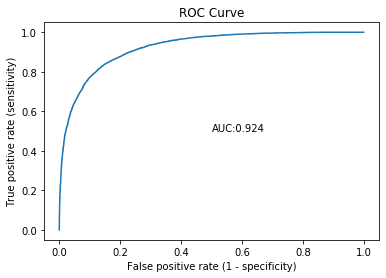

In [52]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc))
plt.title('ROC Curve');

Our dense model has a **ROC AUC** value of **0.924**.

We can also have a look into some of the reviews that were incorrectly classified to have a sense of what's going on. In order to do that, let's create a dataframe with the predicted values for each review and the corresponding original label.

In [40]:
pred_values = []

for prediction in predictions:
    pred_values.append(prediction[0])

In [41]:
df = pd.DataFrame(list(zip(pred_values, y_test)), columns=['y_pred', 'y'])

In [42]:
df.head()

,y_pred,y
0,0.038572,0
1,0.979079,1
2,0.732058,1
3,0.505129,0
4,0.990228,1


Let's focus on the more extreme cases, i. e., misclassified reviews with predicted probabilities of being positive higher than 0.9 or lower than 0.1.

In [43]:
# negative reviews incorrectly classified with predicted probability of being positive > 0.9

df[(df.y == 0) & (df.y_pred > 0.9)].head(10)

,y_pred,y
66,0.946340,0
152,0.955964,0
256,0.903766,0
299,0.928912,0
386,0.976138,0
438,0.907497,0
547,0.972812,0
593,0.960397,0
614,0.918750,0
693,0.975051,0


In [44]:
# check original review with index 66

neg_review = ' '.join(index_word[id] for id in original_x_test[66])

' '.join(neg_review.split()[-100:]) # our model only considers the last 100 words

"comparisons here br br nothing personal here guys i do hope you can make another movie someday and we all have to start out somewhere so forgive me if i've been too harsh i am glad that you are proud of what you created which in the end is what life is all about it's not a movie i would recommend though br br oh i did like the way the time frames often collided thought that was an interesting way to film br br but the whole its the quiet ones you have to watch we already know that"

In [45]:
# positive reviews incorrectly classified with predicted probability of being positive < 0.1

df[(df.y == 1) & (df.y_pred < 0.1)].head(10)

,y_pred,y
72,0.082092,1
100,0.017882,1
101,0.062933,1
159,0.039866,1
167,0.031235,1
248,0.043888,1
300,0.020516,1
325,0.031130,1
333,0.060481,1
345,0.054684,1


In [46]:
# check original review with index 72

pos_review = ' '.join(index_word[id] for id in original_x_test[72])

' '.join(pos_review.split()[-100:]) # our model only considers the last 100 words

"alice is the kind of movie they made in the 30's and 40's never attempts to be an event just wants to entertain and it does i was surprised by kiefer sutherland in a role that could be a cliche he made it real the plot does make allusions to alice in wonderland a guy dressed in white does go through a hole and kiefer does fall down one like alice the plot does twist and turn but with a freshness you don't see in small movies i loved the direction sutherland just a very fast paced and interesting movie"

It's not easy to determine why our model was not able to correctly classify these examples, but it can be useful to have the possibility of doing this kind of ad hoc analysis.

In **step 2** we will now develop a **convolutional classifier**.

### Step 2

#### 1. Perform necessary imports

In [2]:
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D

#### 2. Load data

In [56]:
# considering the 5000 most frequent words as in our first step
# and removing the skip_top parameter

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words)

#### 3. Preprocess data

In [57]:
max_review_length = 400 #maximum review length of 400 words
pad_type = 'pre' #add padding characters to the start of every review < 100 words
trunc_type = 'pre' #remove words from the beginning of every review > 100 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

#### 4. Design a convolutional neural network

In [59]:
# output directory name:
output_dir = 'text_classification_NN/cnn'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# convolutional layer architecture:
n_conv = 256 #number of filters/kernels
k_conv = 3 #kernel length

# dense layer architecture: 
n_dense = 256 #number of neurons
dropout = 0.2

model = Sequential(name='model_cnn')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only have 2 classes

In [60]:
model.summary()

Model: "model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25

Our CNN model is now ready to be compiled and trained.

#### 5. Compile model and create callback to save model parameters

In [61]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [63]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 6. Train model

In [64]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 76s 3ms/step - loss: 0.4973 - accuracy: 0.7331 - val_loss: 0.3134 - val_accuracy: 0.8666
Epoch 2/4
25000/25000 [==============================] - 73s 3ms/step - loss: 0.2485 - accuracy: 0.9002 - val_loss: 0.2744 - val_accuracy: 0.8845
Epoch 3/4
25000/25000 [==============================] - 72s 3ms/step - loss: 0.1701 - accuracy: 0.9360 - val_loss: 0.2703 - val_accuracy: 0.8907
Epoch 4/4
25000/25000 [==============================] - 74s 3ms/step - loss: 0.1151 - accuracy: 0.9596 - val_loss: 0.3025 - val_accuracy: 0.8868


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 3**.

#### 7. Make predictions with the test set

In [65]:
# load parameters of epoch 3

model.load_weights(output_dir+"/weights.03.hdf5")

In [66]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.08455535],
       [0.9976629 ],
       [0.85379833]], dtype=float32)

In [67]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 8. Evaluate model

In [68]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10774  1726]
 [ 1007 11493]]


In [69]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89     12500
           1       0.87      0.92      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [71]:
# accuracy score

acc_cnn = accuracy_score(y_test, predictions_class)
print(acc_cnn)

0.89068


Our CNN model correctly classifies **89,1%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

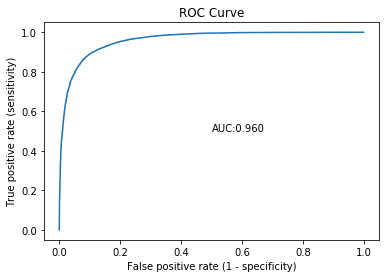

In [72]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_cnn = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_cnn))
plt.title('ROC Curve');

Our CNN model has a **ROC AUC** value of **0.960**.

Our **convolutional model achieved better results than our dense model**.

Let's see if we can improve these results even further with the help of **recurrent neural networks** - this is our **step 3**.

### Step 3

#### 1. Perform necessary imports

In [74]:
from keras.layers import SimpleRNN

#### 2. Load data

In [76]:
# considering the 10000 most frequent words

n_unique_words = 10000 #number of most frequent words to consider

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words)

#### 3. Preprocess data

In [77]:
max_review_length = 100 #maximum review length of 100 words
pad_type = 'pre' #add padding characters to the start of every review < 100 words
trunc_type = 'pre' #remove words from the beginning of every review > 100 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

We will change our neural network by **adding a SimpleRNN() layer** to our model, that as the name suggests is the simplest form of a recurrent layer.

We will also **change some of the hyperparameters** of the model to take into consideration the specificities of RNNs. We have also not included a dense layer after the recurrent layer since it usually does not provide a significant improvement in performance.

#### 4. Design a recurrent neural network (simple RNN layer)

In [78]:
# output directory name:
output_dir = 'text_classification_NN/rnn'

# training:
epochs = 16
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# simple RNN layer architecture:
n_rnn = 256 #number of neurons
drop_rnn = 0.2

model = Sequential(name='model_rnn')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(SimpleRNN(n_rnn, dropout=drop_rnn))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only have 2 classes

In [79]:
model.summary()

Model: "model_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 64)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               82176     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 722,433
Trainable params: 722,433
Non-trainable params: 0
_________________________________________________________________


Our RNN model is now ready to be compiled and trained.

#### 5. Compile model and create callback to save model parameters

In [80]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [82]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 6. Train model

In [83]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/16
25000/25000 [==============================] - 34s 1ms/step - loss: 0.6727 - accuracy: 0.5616 - val_loss: 0.6206 - val_accuracy: 0.6394
Epoch 2/16
25000/25000 [==============================] - 39s 2ms/step - loss: 0.5930 - accuracy: 0.6746 - val_loss: 0.6186 - val_accuracy: 0.6362
Epoch 3/16
25000/25000 [==============================] - 36s 1ms/step - loss: 0.5379 - accuracy: 0.7196 - val_loss: 0.6177 - val_accuracy: 0.6466
Epoch 4/16
25000/25000 [==============================] - 33s 1ms/step - loss: 0.4434 - accuracy: 0.7933 - val_loss: 0.5768 - val_accuracy: 0.7242
Epoch 5/16
25000/25000 [==============================] - 36s 1ms/step - loss: 0.3507 - accuracy: 0.8490 - val_loss: 0.7473 - val_accuracy: 0.6079
Epoch 6/16
25000/25000 [==============================] - 37s 1ms/step - loss: 0.4806 - accuracy: 0.7636 - val_loss: 0.5220 - val_accuracy: 0.7752
Epoch 7/16
25000/25000 [==============================] - 38s 2ms/st

The **highest validation accuracy** is achieved in **epoch 10** and the **lowest validation loss** is achieved in **epoch 8**.

#### 7. Make predictions with the test set

In [84]:
# load parameters of epoch 8

model.load_weights(output_dir+"/weights.08.hdf5")

In [85]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.11321864],
       [0.9625019 ],
       [0.04951205]], dtype=float32)

In [86]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [0]])

#### 8. Evaluate model

In [87]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[ 9802  2698]
 [ 2403 10097]]


In [88]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     12500
           1       0.79      0.81      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



In [89]:
# accuracy score

acc_rnn = accuracy_score(y_test, predictions_class)
print(acc_rnn)

0.79596


Our RNN model correctly classifies **79,6%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

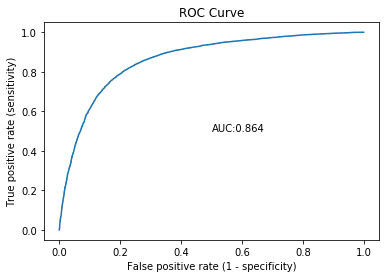

In [90]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_rnn = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_rnn))
plt.title('ROC Curve');

Our RNN model has a **ROC AUC** value of **0.864**.

Our **recurrent model did not perform so well - it had the worst result so far**. This may have happened because simple RNNs are only able to backpropagate through around 10 time steps before the gradient becomes so small that the parameter updates become almost negligible.

Let's see if we can counter this effect by using **more complex RNN architectures** like **Gated Recurrent Units (GRU)** and **Long Short-Term Memory (LSTM)** networks - these are our **steps 4 and 5**.

### Step 4

#### 1. Perform necessary imports

In [92]:
from keras.layers import GRU

We will use the same data we've used before, preprocessed in the same way.

#### 2. Design a recurrent neural network (GRU layer)

In [93]:
# output directory name:
output_dir = 'text_classification_NN/gru'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# GRU layer architecture:
n_gru = 256 #number of neurons
drop_gru = 0.2

model = Sequential(name='model_gru')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(GRU(n_gru, dropout=drop_gru))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

In [94]:
model.summary()

Model: "model_gru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               246528    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 886,785
Trainable params: 886,785
Non-trainable params: 0
_________________________________________________________________


Our new RNN model with a GRU layer is now ready to be compiled and trained.

#### 3. Compile model and create callback to save model parameters

In [96]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [98]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 4. Train model

In [99]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 148s 6ms/step - loss: 0.5231 - accuracy: 0.7136 - val_loss: 0.4070 - val_accuracy: 0.8223
Epoch 2/4
25000/25000 [==============================] - 159s 6ms/step - loss: 0.3064 - accuracy: 0.8738 - val_loss: 0.4044 - val_accuracy: 0.8183
Epoch 3/4
25000/25000 [==============================] - 161s 6ms/step - loss: 0.2551 - accuracy: 0.8974 - val_loss: 0.3638 - val_accuracy: 0.8420
Epoch 4/4
25000/25000 [==============================] - 150s 6ms/step - loss: 0.2019 - accuracy: 0.9229 - val_loss: 0.3870 - val_accuracy: 0.8340


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 3**.

#### 5. Make predictions with the test set

In [101]:
# load parameters of epoch 3

model.load_weights(output_dir+"/weights.03.hdf5")

In [102]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.05291212],
       [0.95099264],
       [0.55228144]], dtype=float32)

In [103]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 6. Evaluate model

In [104]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10865  1635]
 [ 2314 10186]]


In [105]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85     12500
           1       0.86      0.81      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [106]:
# accuracy score

acc_gru = accuracy_score(y_test, predictions_class)
print(acc_gru)

0.84204


Our RNN model with a GRU layer correctly classifies **84,2%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

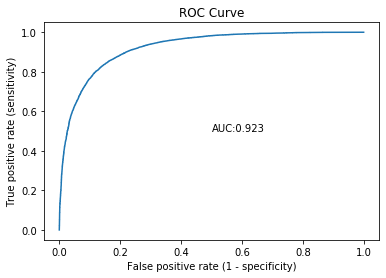

In [107]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_gru = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_gru))
plt.title('ROC Curve');

Our new model has a **ROC AUC** value of **0.923**.

This is an improvement in comparison with our previous model, but it is still worse than our first two models. Let's see if we can improve this result using an **LSTM layer**.

### Step 5

#### 1. Perform necessary imports

In [3]:
from keras.layers import LSTM

#### 2. Design a recurrent neural network (LSTM layer)

In [109]:
# output directory name:
output_dir = 'text_classification_NN/lstm'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# LSTM layer architecture:
n_lstm = 256 #number of neurons
drop_lstm = 0.2

model = Sequential(name='model_lstm')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(LSTM(n_lstm, dropout=drop_lstm))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

In [110]:
model.summary()

Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


Our new RNN model with an LSTM layer is now ready to be compiled and trained.

#### 3. Compile model and create callback to save model parameters

In [111]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [113]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 4. Train model

In [114]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 155s 6ms/step - loss: 0.4947 - accuracy: 0.7504 - val_loss: 0.3501 - val_accuracy: 0.8506
Epoch 2/4
25000/25000 [==============================] - 170s 7ms/step - loss: 0.2985 - accuracy: 0.8780 - val_loss: 0.3449 - val_accuracy: 0.8475
Epoch 3/4
25000/25000 [==============================] - 172s 7ms/step - loss: 0.2410 - accuracy: 0.9046 - val_loss: 0.3880 - val_accuracy: 0.8423
Epoch 4/4
25000/25000 [==============================] - 161s 6ms/step - loss: 0.1996 - accuracy: 0.9246 - val_loss: 0.3658 - val_accuracy: 0.8415


The **highest validation accuracy** is achieved in **epoch 1** and the **lowest validation loss** is achieved in **epoch 2**.

#### 5. Make predictions with the test set

In [115]:
# load parameters of epoch 2

model.load_weights(output_dir+"/weights.02.hdf5")

In [116]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.24716255],
       [0.9733419 ],
       [0.7759752 ]], dtype=float32)

In [117]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 6. Evaluate model

In [118]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10195  2305]
 [ 1507 10993]]


In [119]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84     12500
           1       0.83      0.88      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [120]:
# accuracy score

acc_lstm = accuracy_score(y_test, predictions_class)
print(acc_lstm)

0.84752


Our RNN model with an LSTM layer correctly classifies **84,8%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

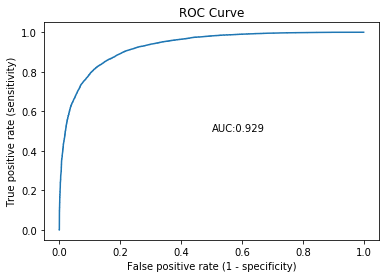

In [121]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_lstm = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_lstm))
plt.title('ROC Curve');

This model has a **ROC AUC** value of **0.929**. 

This represents a slight improvement from the previous model, but is still lower than the ROC AUC value of our CNN model.

In **step 6** we will try to improve our results with the help of a **bidirectional LSTM**.

### Step 6

#### 1. Perform necessary imports

In [4]:
from keras.layers.wrappers import Bidirectional

#### 2. Load data

In [5]:
# considering the 10000 most frequent words

n_unique_words = 10000 #number of most frequent words to consider

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words)

#### 3. Preprocess data

In [6]:
max_review_length = 200 #maximum review length of 200 words
pad_type = 'pre' #add padding characters to the start of every review < 100 words
trunc_type = 'pre' #remove words from the beginning of every review > 100 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

#### 4. Design a recurrent neural network (bi-LSTM layer)

In [7]:
# output directory name:
output_dir = 'text_classification_NN/bi-lstm'

# training:
epochs = 6
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# bi-LSTM layer architecture:
n_lstm = 256 #number of neurons
drop_lstm = 0.2

model = Sequential(name='model_bi-lstm')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

In [8]:
model.summary()

Model: "model_bi-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               657408    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


Our new RNN model with a bidirectional LSTM layer is now ready to be compiled and trained.

#### 5. Compile model and create callback to save model parameters

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [11]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 6. Train model

In [130]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 908s 36ms/step - loss: 0.5455 - accuracy: 0.7174 - val_loss: 0.3824 - val_accuracy: 0.8360
Epoch 2/6
25000/25000 [==============================] - 1036s 41ms/step - loss: 0.3061 - accuracy: 0.8757 - val_loss: 0.3268 - val_accuracy: 0.8680
Epoch 3/6
25000/25000 [==============================] - 1110s 44ms/step - loss: 0.2311 - accuracy: 0.9121 - val_loss: 0.3336 - val_accuracy: 0.8648
Epoch 4/6
25000/25000 [==============================] - 1022s 41ms/step - loss: 0.1924 - accuracy: 0.9274 - val_loss: 0.3544 - val_accuracy: 0.8641
Epoch 5/6
25000/25000 [==============================] - 1070s 43ms/step - loss: 0.1525 - accuracy: 0.9451 - val_loss: 0.4024 - val_accuracy: 0.8573
Epoch 6/6
25000/25000 [==============================] - 1056s 42ms/step - loss: 0.1252 - accuracy: 0.9545 - val_loss: 0.4122 - val_accuracy: 0.8618


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 2**.

#### 7. Make predictions with the test set

In [131]:
# load parameters of epoch 2

model.load_weights(output_dir+"/weights.02.hdf5")

In [132]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.17112471],
       [0.96590513],
       [0.5913159 ]], dtype=float32)

In [134]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 8. Evaluate model

In [135]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[11025  1475]
 [ 1825 10675]]


In [136]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.85      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [137]:
# accuracy score

acc_bilstm = accuracy_score(y_test, predictions_class)
print(acc_bilstm)

0.868


Our RNN model with a bidirectional LSTM layer correctly classifies **86,8%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

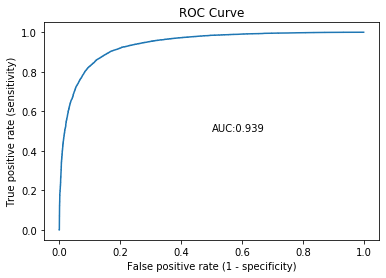

In [138]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_bilstm = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_bilstm))
plt.title('ROC Curve');

Our bi-LSTM model has a **ROC AUC** value of **0.939**.

This is our second best model so far, only surpassed in terms of performance by our CNN model.

We can try to **stack bi-LSTM layers** to improve our results - that's what we will do in **step 7**.

### Step 7

For this step, we will use exactly the same data we've used in step 6, preprocessed in the same way.

#### 1. Design a stacked recurrent neural network (2 bi-LSTM layers)

In [12]:
# output directory name:
output_dir = 'text_classification_NN/stacked_bi-lstm'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# stacked bi-LSTM layer architecture:
n_lstm_1 = 64 #number of neurons of LSTM layer 1
n_lstm_2 = 64 #number of neurons of LSTM layer 2
drop_lstm = 0.2
rec_drop_lstm = 0.2 #recurrent dropout

model = Sequential(name='model_stacked_bi-lstm')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, recurrent_dropout=rec_drop_lstm, return_sequences=True)))
#with return_sequences=True this recurrent layer returns the hidden states for each step of the sequence

model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm, recurrent_dropout=rec_drop_lstm)))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

Since both our **LSTM and bidirectional LSTM models seem to show a slight tendency to overfit**, we've also included a **recurrent dropout value of 0.2 in our 2 LSTM layers**, along with the regular dropout value.

In [13]:
model.summary()

Model: "model_stacked_bi-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 128)          66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 804,993
Trainable params: 804,993
Non-trainable params: 0
_________________________________________________________________


Our stacked RNN model is now ready to be compiled and trained.

#### 2. Compile model and create callback to save model parameters

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [16]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 3. Train model

In [149]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 714s 29ms/step - loss: 0.4802 - accuracy: 0.7622 - val_loss: 0.3444 - val_accuracy: 0.8566
Epoch 2/4
25000/25000 [==============================] - 699s 28ms/step - loss: 0.3286 - accuracy: 0.8639 - val_loss: 0.3974 - val_accuracy: 0.8188
Epoch 3/4
25000/25000 [==============================] - 702s 28ms/step - loss: 0.2893 - accuracy: 0.8858 - val_loss: 0.3817 - val_accuracy: 0.8425
Epoch 4/4
25000/25000 [==============================] - 703s 28ms/step - loss: 0.2535 - accuracy: 0.9016 - val_loss: 0.3448 - val_accuracy: 0.8591


After the 4 epochs of training, the results are not conclusive. We've decided to extend the training for 4 more epochs, making a total of 8 epochs. If this was done right after the first 4 epochs of training, we just had to call `.fit()` again.

Since this training is being done after a break and not immediately after the first 4 epochs, we need to load the model weights, model architecture, compilation details and optimizer state (since we're using the Adam optimizer we have an adaptive learning rate, i.e., the learning rate changes with time).

In order to do this, we can use the Keras `load_model()` function. 

In [21]:
from keras.models import load_model

model = load_model(output_dir+"/weights.04.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=8, verbose=1, initial_epoch=4, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 5/8
25000/25000 [==============================] - 516s 21ms/step - loss: 0.2131 - accuracy: 0.9198 - val_loss: 0.3691 - val_accuracy: 0.8569
Epoch 6/8
25000/25000 [==============================] - 500s 20ms/step - loss: 0.1773 - accuracy: 0.9372 - val_loss: 0.3675 - val_accuracy: 0.8548
Epoch 7/8
25000/25000 [==============================] - 529s 21ms/step - loss: 0.1526 - accuracy: 0.9452 - val_loss: 0.3879 - val_accuracy: 0.8598
Epoch 8/8
25000/25000 [==============================] - 549s 22ms/step - loss: 0.1921 - accuracy: 0.9267 - val_loss: 0.3823 - val_accuracy: 0.8500


After the 8 epochs of training, the **highest validation accuracy** is achieved in **epoch 7** and the **lowest validation loss** is achieved in **epoch 1**.

Our model shows some signs of overfiting even after the introduction of recurrent dropout. We'll leave it like it is for now.

#### 4. Make predictions with the test set

In [23]:
# load parameters of epoch 1

model.load_weights(output_dir+"/weights.01.hdf5")

In [24]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.24861364],
       [0.9267259 ],
       [0.77547264]], dtype=float32)

In [25]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 5. Evaluate model

In [28]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[11008  1492]
 [ 2094 10406]]


In [29]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     12500
           1       0.87      0.83      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [31]:
# accuracy score

acc_stacked_bilstm = accuracy_score(y_test, predictions_class)
print(acc_stacked_bilstm)

0.85656


Our stacked RNN model with 2 bidirectional LSTMs layer correctly classifies **85,7%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

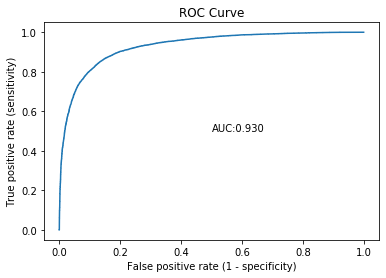

In [34]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_stacked_bilstm = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_stacked_bilstm))
plt.title('ROC Curve');

Our stacked RNN model has a **ROC AUC** value of **0.930**.

This means we were not able to improve our previous result. We'll get back to this at a later stage.

In **step 8**, and since our best result so far was obtained by our convolutional model, we'll try a different approach: an **LSTM layer stacked on top of a convolutional layer**.

### Step 8